# Summarisation and Controlled Text Generation with T-5

In this notebook, we will see how to fine-tune one of the [HuggingFace Transformers](https://github.com/huggingface/transformers) model (T5) for the summarisation task and the task of controlled text generation with keywords. We will use the [XSum dataset](https://arxiv.org/pdf/1808.08745.pdf) (for extreme summarisation) which contains long BBC articles and their single-sentence summaries.

[T5](https://paperswithcode.com/method/t5) is a popular model, which is designed as a text-to-text multi-task model. For each task, both input and output is text (so that for a regression task, a number 2.5 becomes a string "2.5"). Hence we can use the same model for a range of tasks including translation, linguistic acceptability, sentence similarity, document summarisation (our case), etc.

We will start by installing 🤗 Huggingface Transformers and 🤗 Huggingface Datasets as well as other dependencies.

Much of our code is based on the [official tutorial](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/summarization-tf.ipynb).

In [72]:
! pip install transformers datasets
! pip install rouge-score nltk
! pip install huggingface_hub

## Loading the Dataset




We will use the [HuggingFace Datasets](https://github.com/huggingface/datasets) library to download the data. This a very good resource for easy manipulation of commonly used datasets.

In [73]:
from datasets import list_datasets, load_dataset

# If the training time is too much and you do not have GPU / TPU then uncomment the below line and re-run the notebook
# Note that here we are reducing the size of the dataset hence the values are going to be different then what you will see when you run it on full dataset
# original_datasets = load_dataset("xsum", trust_remote_code=True, split="validation[:2%]")
original_datasets = load_dataset("xsum", trust_remote_code=True, split="validation[:10%]")

We will further create a train and a validation set by splitting the original validation set.

In [74]:
import datasets as ds

# We will use only the validation set due to the lack of computational resources
# Split the initial validation set
train_valid = original_datasets.train_test_split(test_size=0.25)

# Gather the sets into a single DatasetDict
raw_datasets = ds.DatasetDict({'train': train_valid['train'], 'validation': train_valid['test']})

In [75]:
print(raw_datasets["train"][0])

{'document': 'Mr LaBeouf was arrested following a confrontation at his live-streamed video project in New York, and was charged with assault and harassment.\nThose charges have now been dropped.\nA spokeswoman for the district attorney in New York\'s Queen\'s district told US media the case would be dismissed because of insufficient evidence.\nMr LaBeouf\'s art project, a 24-hour live stream called He Will Not Divide Us, encouraged members of the public to say those words into a camera outside New York\'s Museum of the Moving Image.\nBut Mr LaBeouf and a member of the public allegedly entered an altercation during a live broadcast in January.  The museum later said the site had become "a flashpoint for violence".\nThe live stream was planned to continue for the four years of Mr Trump\'s presidency, but the museum pulled support for the project in early February.\nThe project was forced to move location twice in the US, after opponents tried to disrupt it.\nIt then arrived in a new form

### Some Data Analysis

Here we will perform some basic exploratory data analysis by computing the mean and standard deviation of token counts for the source and target documents.

The `show_random_elements` method below displays a table containing `num_examples` samples from the specified `dataset`, with fields `document`, `summary` and `id`

**Task 1: Summarisation data statistics**

Complete the functions below by tokenising the documents (the best option would be to use the tokeniser but here you can just split on spaces) and print the mean token count and standard deviation for source and target documents for each dataset. Plot histograms of the source and target token counts (method `show_token_counts` is provided). Comment on the lengths of input and target texts for summarisation.

,document,summary,id
0,"In February, clubs agreed ""in principle"" to use the system from next season and those plans were confirmed at an EGM on 6 April.\nGoalline technology has been used in the Premier League since 2013.\nIt has also been utilised in previous Football League play-off finals.\nHowever, this season the technology will be available for both Championship semi-finals, as well as the final at Wembley on Monday, 29 May.\n""The introduction of goalline technology is a significant step forward for Championship clubs and reflects the importance of the outcome of every single game in the division,"" said EFL chief executive Shaun Harvey.\n""It has already proved successful elsewhere in our competitions and I'm confident it will have a similar positive impact week in, week out in the Championship, starting with this year's Championship play-off semi-finals.""","Goalline technology will be used in this season's Championship play-offs before being introduced in all second-tier matches in 2017-18, the English Football League has said.",39578985
1,"He is the highest-ranking US official to publicly implicate Beijing since news of the data breach emerged.\nChina always dismissed suggestions that it was behind the hacking.\nThe statement comes after three days of high-level talks in which China and the US agreed to a ""code of conduct"".\n""China remains the leading suspects,"" said Mr Clapper at a conference in Washington DC, but ""the US government continues to investigate"" he added, according to his office.\nBackground to a ""massive"" hack in five points\nUS hit by 'massive data breach'\nChina military unit 'behind prolific hacking'\nAt the Washington talks where cyber security was a top priority, US Secretary of State John Kerry said there was a need to work with China to develop a ""code of conduct"" on state behaviour in cyberspace - Chinese representatives had agreed with these conclusions.\n""It's something that we agreed needs to be addressed and hopefully it can be addressed soon,"" State Department spokesman John Kirby said on Thursday.\nChina has said any suggestion that it was behind the hacking is ""irresponsible and unscientific"".","China is the ""leading suspect"" in the massive hack of a US government agency holding the personnel records of millions of Americans, US intelligence chief James Clapper has said.",33281269
2,"Joanne Lees said she believed his missing body could still be found.\nThe 43-year-old returned to the Outback as part of a TV special, revisiting the place where the 28-year-old was shot.\nBradley Murdoch was convicted in 2005 of murdering Mr Falconio and assaulting Ms Lees, then 27, on a remote stretch of highway on July 14 2001.\nThe murder took place near Barrow Creek, about 200 miles north of Alice Springs.\nThe couple, from Huddersfield, were travelling when Murdoch waved down their camper van and shot Mr Falconio in the head.\nMs Lees was threatened with a gun, punched in the head and bound with cable-tie restraints before she managed to escape, hiding in bushes for hours while her attacker stalked her with a dog.\nMurdoch is believed to have hidden Mr Falconio's body, which has never been found, despite extensive searches.\nMs Lees said she had ""no choice"" but to run from Murdoch because ""it was either run or be raped and killed"".\nIn adverts for the special edition of 60 Minutes, she says: ""Pete's still missing. I know that he's somewhere here.""\nAsked if she is ""stepping inside"" her attacker's mind, she says: ""I guess it is a very alien thing for me to do because I'm not a violent person.\n""I'm not a murderer but if that's what I have to do and that's how I'm gong to find Pete then that's what I'm prepared to do.""\nShe adds: ""It's because I love Pete so much and I want to bring him home and I need to bring him home.""\nNorthern Territory Police renewed its appeal to help find his remains last year.\nThe interview will be aired on Channel Nine in Australia at 21:40 GMT 

TRAIN SET:
Source Mean: 381.27, Source StdDev: 318.55
Target Mean: 21.15, Target StdDev: 5.41

VALIDATION SET:
Source Mean: 346.34, Source StdDev: 266.02
Target Mean: 20.88, Target StdDev: 4.76



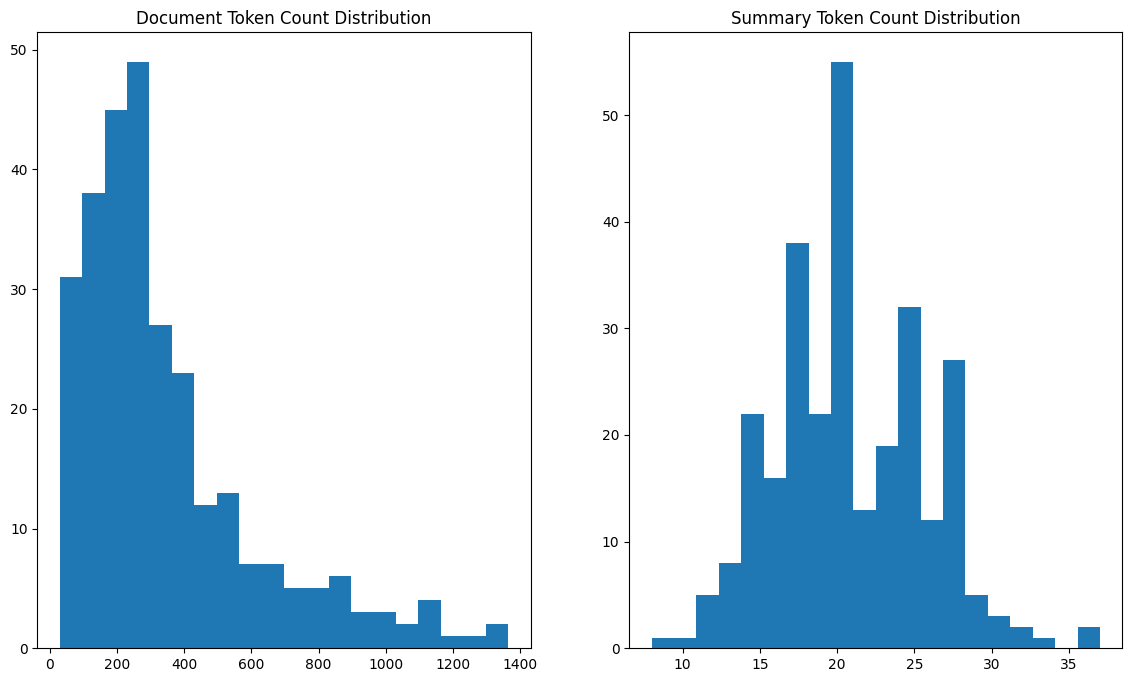

In [76]:
import datasets
import random
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt

def show_random_elements(dataset, num_examples=5):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))


def calculate_token_counts(dataset):
    source_counts = [len(row['document'].split()) for row in dataset]
    target_counts = [len(row['summary'].split()) for row in dataset]
    return source_counts, target_counts

def token_counts_summary(raw_datasets):
    for split, dataset in raw_datasets.items():
        source_counts, target_counts = calculate_token_counts(dataset)
        print(f"{split.upper()} SET:")
        print(f"Source Mean: {np.mean(source_counts):.2f}, Source StdDev: {np.std(source_counts):.2f}")
        print(f"Target Mean: {np.mean(target_counts):.2f}, Target StdDev: {np.std(target_counts):.2f}\n")


def show_token_counts(dataset):
    source_counts, target_counts = calculate_token_counts(dataset)
    f, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 8))
    ax0.hist(source_counts, bins=20)
    ax1.hist(target_counts, bins=20)
    ax0.set_title("Document Token Count Distribution")
    ax1.set_title("Summary Token Count Distribution")

show_random_elements(raw_datasets["validation"])
show_token_counts(raw_datasets["validation"])
token_counts_summary(raw_datasets)

### ROUGE Metric

To evaluate our model's performance, we will use **ROUGE (Recall-Oriented Understudy for Gisting Evaluation)**. It compares *n*-grams of the model outputs to reference text but is based on recall instead of precision like BLEU. ROUGE does not impose any brevity penalty. BLEU returns a single number, ROUGE outputs multiple scores per each $n$-gram under consideration.

This metric is provided natively within the dataset library. **Note** metrics are difficult to implement correctly from scratch as decisions like lemmatisation, tokenisation and punctation-handling can create large discrepancies in scores.

You can call its `compute` method with your hypotheses and target summaries, which need to be list of decoded strings:

In [77]:
from datasets import load_metric
metric = load_metric("rouge", trust_remote_code=True)

# help(metric)      # << Uncomment to see more about the ROUGE eval metric

predicted_summaries = ["AI applications span diverse fields.", "Enhancing efficiency, decision-making, experiences with AI."]
target_doc = 'As artificial intelligence continues to advance, researchers are exploring its applications in diverse fields such as healthcare, finance, education, and entertainment, aiming to improve efficiency, decision-making processes, and overall human experiences.'
docs = [target_doc, target_doc]

metric.compute(predictions=predicted_summaries, references=docs)

{'rouge1': AggregateScore(low=Score(precision=0.5714285714285714, recall=0.09375, fmeasure=0.16216216216216214), mid=Score(precision=0.5857142857142856, recall=0.109375, fmeasure=0.18364518364518362), high=Score(precision=0.6, recall=0.125, fmeasure=0.20512820512820512)),
 'rouge2': AggregateScore(low=Score(precision=0.25, recall=0.03225806451612903, fmeasure=0.05714285714285715), mid=Score(precision=0.29166666666666663, recall=0.04838709677419355, fmeasure=0.08262548262548262), high=Score(precision=0.3333333333333333, recall=0.06451612903225806, fmeasure=0.1081081081081081)),
 'rougeL': AggregateScore(low=Score(precision=0.5714285714285714, recall=0.09375, fmeasure=0.16216216216216214), mid=Score(precision=0.5857142857142856, recall=0.109375, fmeasure=0.18364518364518362), high=Score(precision=0.6, recall=0.125, fmeasure=0.20512820512820512)),
 'rougeLsum': AggregateScore(low=Score(precision=0.5714285714285714, recall=0.09375, fmeasure=0.16216216216216214), mid=Score(precision=0.58571

## Preprocessing the Data

We will proprocess the data using the Huggingface `Tokenizer` paired with T5, which tokenises input text and adds additional required tokens. This ensures that our inputs are correctly aligned with the model's embedding matrix.

In [78]:
from transformers import AutoTokenizer

model_checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

### Using the Tokenizer

`Tokenizer` outputs are different for different tokenisers. Compare outputs below for the T5 and BERT tokenisers.


In [79]:
print(tokenizer("AI applications span diverse fields."))

tokenizer_ = AutoTokenizer.from_pretrained('bert-base-uncased')
tokenizer_('AI applications span diverse fields.')

{'input_ids': [7833, 1564, 8438, 2399, 4120, 5, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


{'input_ids': [101, 9932, 5097, 8487, 7578, 4249, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

As we mentioned above, T5 was trained in a multitask setup such that it can perform multiple tasks. We prefix the inputs with "summarize: " to prompt the model to summarise.

We will now create a function to preprocess our samples, feeding them to the tokeniser with the `truncation=True` argument. This ensures that any input exceeding the model's maximum accepted length will be truncated accordingly. Padding will be addressed later in a data collator, allowing us to pad examples to the longest length in the batch rather than the entire dataset.

Complete the `preprocess_function` below to prepare our training data (**Hint**: do not forget to prefix the inputs).

In [80]:
if model_checkpoint in ["t5-small", "t5-base", "t5-large", "t5-3b", "t5-11b"]:
    prefix = "summarize: "
else:
    prefix = ""

In [81]:
max_doc_len = 1024
max_sum_length = 128


def preprocess_samples(samples):

    inputs = list()

    # TO DO
    # Prefixing each document in the dataset with "summarize: "
    inputs = ["summarize: " + doc for doc in samples["document"]]

    # Tokenizing the inputs with truncation and padding (handled later in a data collator)
    model_inputs = tokenizer(inputs, max_length=max_doc_len, truncation=True, padding="longest")
    # TO DO
    targets = tokenizer(text_target = samples["summary"], max_length=max_sum_length, truncation=True)
    model_inputs["labels"] = targets["input_ids"]

    return model_inputs

This function works with one or several examples. In the case of several examples, the tokeniser will return a list of lists for each key:

In [82]:
raw_datasets["train"][:2]

{'document': ['Mr LaBeouf was arrested following a confrontation at his live-streamed video project in New York, and was charged with assault and harassment.\nThose charges have now been dropped.\nA spokeswoman for the district attorney in New York\'s Queen\'s district told US media the case would be dismissed because of insufficient evidence.\nMr LaBeouf\'s art project, a 24-hour live stream called He Will Not Divide Us, encouraged members of the public to say those words into a camera outside New York\'s Museum of the Moving Image.\nBut Mr LaBeouf and a member of the public allegedly entered an altercation during a live broadcast in January.  The museum later said the site had become "a flashpoint for violence".\nThe live stream was planned to continue for the four years of Mr Trump\'s presidency, but the museum pulled support for the project in early February.\nThe project was forced to move location twice in the US, after opponents tried to disrupt it.\nIt then arrived in a new for

In [83]:
preprocess_samples(raw_datasets["train"][:2])

{'input_ids': [[21603, 10, 1363, 325, 2703, 1063, 89, 47, 10195, 826, 3, 9, 25704, 44, 112, 619, 18, 8103, 15, 26, 671, 516, 16, 368, 1060, 6, 11, 47, 4977, 28, 12710, 11, 23556, 5, 3, 3405, 3991, 43, 230, 118, 6292, 5, 71, 5468, 7, 15893, 21, 8, 3939, 4917, 16, 368, 1060, 31, 7, 5286, 31, 7, 3939, 1219, 837, 783, 8, 495, 133, 36, 19664, 250, 13, 16, 17817, 2084, 5, 1363, 325, 2703, 1063, 89, 31, 7, 768, 516, 6, 3, 9, 12371, 5842, 619, 6093, 718, 216, 2003, 933, 22390, 6952, 6, 6470, 724, 13, 8, 452, 12, 497, 273, 1234, 139, 3, 9, 1861, 1067, 368, 1060, 31, 7, 3312, 13, 8, 15510, 6298, 5, 299, 1363, 325, 2703, 1063, 89, 11, 3, 9, 1144, 13, 8, 452, 3, 18280, 5136, 46, 8310, 75, 257, 383, 3, 9, 619, 6878, 16, 1762, 5, 37, 7071, 865, 243, 8, 353, 141, 582, 96, 9, 4923, 2700, 21, 4756, 1280, 37, 619, 6093, 47, 4355, 12, 916, 21, 8, 662, 203, 13, 1363, 2523, 31, 7, 27405, 6, 68, 8, 7071, 6756, 380, 21, 8, 516, 16, 778, 2083, 5, 37, 516, 47, 5241, 12, 888, 1128, 4394, 16, 8, 837, 6, 227, 163

We will apply the `map` method of our `raw_datasets` object we created earlier. This will apply the function on all the elements of all the splits in `dataset`, so our training, validation and testing data will be preprocessed in one single command.

In [84]:
preprocessed_datasets = raw_datasets.map(preprocess_samples, batched=True)

Map:   0%|          | 0/849 [00:00<?, ? examples/s]

Map:   0%|          | 0/284 [00:00<?, ? examples/s]

The outcomes are automatically stored in the 🤗 Datasets library's cache, so that processing does not need to be repeated. If you need to reapply preprocessing, you can include `load_from_cache_file=False` in the map function call.

We specified `batched=True `to encode texts in batches which employs multi-threading.

## Fine-tuning T5

We will now download the pretrained model and fine-tune it. Since our task is sequence-to-sequence, we use the `AutoModelForSeq2SeqLM` class.

In [85]:
from transformers import TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq

model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Let's set the learning rate, `batch_size` and customise the weight decay.

In [86]:
batch_size = 8
learning_rate = 2e-5
weight_decay = 0.01
num_train_epochs = 1

model_name = model_checkpoint.split("/")[-1]
push_to_hub_model_id = f"{model_name}-finetuned-xsum"

Next, we build a data collator that pads the inputs to the batch's maximum length for both inputs ans targets. Make sure to set the `return_tensors='np'` argument to obtain NumPy arrays. Our TensorFlow dataset pipeline internally employs a NumPy loader, wrapped with a tf.data.Dataset at the end. Additionally, np is required by the ROUGE metrics.


To speed up GPU computation, we specify `pad_to_multiple_of`, which snaps the padding length to the next multiple of the given value. For example, if we pad to 250 but pad_to_multiple_of=8 then we will pad to 256.

In [87]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np")

generation_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np", pad_to_multiple_of=128)

We will convert our datasets into tf.data.Dataset, to be able to work with Keras. We will use Model.prepare_tf_dataset() to avoid manual specification. We re-use the collator we created earlier as our `collate_fn`.

In [88]:
train_dataset = model.prepare_tf_dataset(
    preprocessed_datasets["train"],
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_collator,
)

validation_dataset = model.prepare_tf_dataset(
    preprocessed_datasets["validation"],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator,
)

Now we initialise our loss and optimizer and compile the model. Note that most Transformers models compute loss internally, so we do not need to specify any loss when we `compile()`.

In [89]:
from transformers import AdamWeightDecay
import tensorflow as tf

optimizer = AdamWeightDecay(learning_rate=learning_rate, weight_decay_rate=weight_decay)
model.compile(optimizer=optimizer)

Finally, we can train our model. KerasMetricCallback is a callback for computing advanced metrics. The callback takes two main arguments: `metric_fn` and `eval_dataset`. It then iterates the `eval_dataset` and collects the model's outputs for each sample. As a result, the callback passes the `list` of predictions and the associated `list` of targets to the user-defined `metric_fn`. If the `predict_with_generate` argument is `True`, then it will call `model.generate()`. This is useful for metrics like `ROUGE`.

Complete the `compute_metrics` below to decode output batches and compute ROUGE (**Hint**: you can use `tokenizer.batch_decode` and `metric.compute`).

In [90]:
import numpy as np
import nltk
from datasets import load_metric

# Loading the ROUGE metric
rouge = load_metric("rouge")

def compute_metrics(eval_predictions):

    model_predictions, true_labels = eval_predictions

    # Substitute masked true label tokens
    for label in true_labels:
        label[label < 0] = tokenizer.pad_token_id

    # TO DO
    decoded_predictions = tokenizer.batch_decode(model_predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(true_labels, skip_special_tokens=True)
    # TO DO

    # Rouge expects a newline after each sentence
    decoded_predictions = [
        "\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_predictions
    ]
    decoded_targets = [
        "\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels
    ]

    # TO DO
    rouge_results = rouge.compute(predictions=decoded_predictions, references=decoded_labels)
    # TO DO

    # Extract relevant results
    rouge_results = {key: value.mid.fmeasure * 100 for key, value in rouge_results.items()}

    # Include mean generated length
    prediction_lengths = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in model_predictions
    ]
    rouge_results["gen_len"] = np.mean(prediction_lengths)

    return rouge_results


/usr/local/lib/python3.10/dist-packages/datasets/load.py:753: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


We will train our model now. We only do a single epoch, as inputs are very long and even one epoch can take a while.

In [91]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [92]:
from transformers.keras_callbacks import PushToHubCallback, KerasMetricCallback

metric_callback = KerasMetricCallback(
    compute_metrics, eval_dataset=validation_dataset, predict_with_generate=True
)

callbacks = [metric_callback]

model.fit(
    train_dataset, epochs=1, callbacks=callbacks)

  6/106 [>.............................] - ETA: 1:06 - loss: 4.0617

106/106 [==============================] - ETA: 0s - loss: 3.4227

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:838: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length.  recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


106/106 [==============================] - 229s 2s/step - loss: 3.4227 - rouge1: 18.0725 - rouge2: 3.0025 - rougeL: 14.5640 - rougeLsum: 14.6160 - gen_len: 18.8556


## Inference

**Let**'s try now to summarise a document using our model. Do not forget to prepend "summarize: " to the input.

In [93]:


document = 'The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.\nRepair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.\nTrains on the west coast mainline face disruption due to damage at the Lamington Viaduct.\nMany businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.\nFirst Minister Nicola Sturgeon visited the area to inspect the damage.\nThe waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.\nJeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.\nHowever, she said more preventative work could have been carried out to ensure the retaining wall did not fail.\n"It is difficult but I do think there is so much publicity for Dumfries and the Nith - and I totally appreciate that - but it is almost like we\'re neglected or forgotten," she said.\n"That may not be true but it is perhaps my perspective over the last few days.\n"Why were you not ready to help us a bit more when the warning and the alarm alerts had gone out?"\nMeanwhile, a flood alert remains in place across the Borders because of the constant rain.\nPeebles was badly hit by problems, sparking calls to introduce more defences in the area.\nScottish Borders Council has put a list on its website of the roads worst affected and drivers have been urged not to ignore closure signs.\nThe Labour Party\'s deputy Scottish leader Alex Rowley was in Hawick on Monday to see the situation first hand.\nHe said it was important to get the flood protection plan right but backed calls to speed up the process.\n"I was quite taken aback by the amount of damage that has been done," he said.\n"Obviously it is heart-breaking for people who have been forced out of their homes and the impact on businesses."\nHe said it was important that "immediate steps" were taken to protect the areas most vulnerable and a clear timetable put in place for flood prevention plans.'
summary = 'Severe flooding in Newton Stewart and surrounding areas has caused extensive damage, ongoing repair efforts, disruptions to transportation, and calls for improved flood prevention measures, prompting visits from First Minister Nicola Sturgeon and concerns from local businesses and residents.'
# Prepare the text to be summarized by the model
input_text = "summarize: " + document
tokenized = tokenizer(input_text, return_tensors='tf', truncation=True , max_length=1024)
# Generate the summary with the model
out = model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'], max_length=150, length_penalty=2.0, num_beams=4, early_stopping=True)


In [94]:
out_ft = tokenizer.decode(out[0], skip_special_tokens=True)
print(out_ft)

The full cost of damage in Newton Stewart is still being assessed. many roads in Peeblesshire remain badly affected by flooding.


## Pipeline API

The pipeline API provides a convienient shortcut to many procedures. Let's use it to generate a summary with the non fine-tuned model.

In [95]:
from transformers import pipeline

# we will use the initial T5 checkpoint we downloaded before fine-tuning
summarizer = pipeline('text2text-generation', model_checkpoint, framework="tf")

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


**Task 2: Compare performance of the fine-tuned model to generic output**

Summarise the document provided above using the generic model (no fine-tuning). Compute ROUGE scores and comment on the efficiency of fine-tuning.

In [96]:
out = summarizer(document, max_length=128)
out_zero_shot = out[0]['generated_text']
print(out_zero_shot)

the flood protection plan was right but backed calls to speed up the process . the full cost of damage in Newton Stewart is still being assessed . many roads in Peeblesshire remain badly affected by standing water .


In [97]:
metric.compute(predictions=[out_ft], references=[summary])

{'rouge1': AggregateScore(low=Score(precision=0.23809523809523808, recall=0.1282051282051282, fmeasure=0.16666666666666666), mid=Score(precision=0.23809523809523808, recall=0.1282051282051282, fmeasure=0.16666666666666666), high=Score(precision=0.23809523809523808, recall=0.1282051282051282, fmeasure=0.16666666666666666)),
 'rouge2': AggregateScore(low=Score(precision=0.1, recall=0.05263157894736842, fmeasure=0.06896551724137931), mid=Score(precision=0.1, recall=0.05263157894736842, fmeasure=0.06896551724137931), high=Score(precision=0.1, recall=0.05263157894736842, fmeasure=0.06896551724137931)),
 'rougeL': AggregateScore(low=Score(precision=0.14285714285714285, recall=0.07692307692307693, fmeasure=0.1), mid=Score(precision=0.14285714285714285, recall=0.07692307692307693, fmeasure=0.1), high=Score(precision=0.14285714285714285, recall=0.07692307692307693, fmeasure=0.1)),
 'rougeLsum': AggregateScore(low=Score(precision=0.14285714285714285, recall=0.07692307692307693, fmeasure=0.1), mi

In [98]:
metric.compute(predictions=[out_zero_shot], references=[summary])

{'rouge1': AggregateScore(low=Score(precision=0.19444444444444445, recall=0.1794871794871795, fmeasure=0.18666666666666665), mid=Score(precision=0.19444444444444445, recall=0.1794871794871795, fmeasure=0.18666666666666665), high=Score(precision=0.19444444444444445, recall=0.1794871794871795, fmeasure=0.18666666666666665)),
 'rouge2': AggregateScore(low=Score(precision=0.05714285714285714, recall=0.05263157894736842, fmeasure=0.05479452054794521), mid=Score(precision=0.05714285714285714, recall=0.05263157894736842, fmeasure=0.05479452054794521), high=Score(precision=0.05714285714285714, recall=0.05263157894736842, fmeasure=0.05479452054794521)),
 'rougeL': AggregateScore(low=Score(precision=0.08333333333333333, recall=0.07692307692307693, fmeasure=0.08), mid=Score(precision=0.08333333333333333, recall=0.07692307692307693, fmeasure=0.08), high=Score(precision=0.08333333333333333, recall=0.07692307692307693, fmeasure=0.08)),
 'rougeLsum': AggregateScore(low=Score(precision=0.0833333333333

## Textual data generation using keywords


One possible way to generate new text for data augmentation is to guide the generation of new text using keywords extracted from original data. In this task, you will fine-tune T5 to generate new text based on keywords extracted from the original summaries of the XSum dataset you have seen in the first part of this lab.  Fine-tuning T5 on such a task would leverage the model capabilities to produce new text that captures the core meaning of the original based on the provided keywords.

**Task 3: Build and evaluate a T5-based model for data generation using keywords.**

Complete the `preprocess_samples_data_gen` below to extract 10 random words from each summary. Those ten random words will be further tokenised and used as inputs to T5. Note that in this task you do not need to prepend "summarize: ".

In [99]:
def preprocess_samples_data_gen(samples):

    inputs = list()

    for doc in samples["summary"]:
      # TO DO
      # Split the summary into words
      words = doc.split()

      # Randomly select 10 words or all words if there are fewer than 10
      selected_words = random.sample(words, min(len(words), 10))

      # Join these words into a string separated by spaces
      input_str = " ".join(selected_words)
      inputs.append(input_str)

    model_inputs = tokenizer(inputs, max_length=max_doc_len, truncation=True)
    targets = tokenizer(text_target = samples["summary"], max_length=max_sum_length, truncation=True)

    model_inputs["labels"] = targets["input_ids"]

    return model_inputs

Now we can preprocess, collate and prepare our new dataset in the similar way we have done before.

In [100]:
preprocessed_datasets_data_gen = raw_datasets.map(preprocess_samples_data_gen, batched=True)

Map:   0%|          | 0/849 [00:00<?, ? examples/s]

Map:   0%|          | 0/284 [00:00<?, ? examples/s]

In [101]:
from transformers import TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq

model_data_gen = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [102]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_data_gen, return_tensors="np")

generation_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_data_gen, return_tensors="np", pad_to_multiple_of=128)

In [103]:
train_dataset = model.prepare_tf_dataset(
    preprocessed_datasets_data_gen["train"],
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_collator,
)

validation_dataset = model.prepare_tf_dataset(
    preprocessed_datasets_data_gen["validation"],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator,
)

generation_dataset = model.prepare_tf_dataset(
    preprocessed_datasets_data_gen["validation"],
    batch_size=8,
    shuffle=False,
    collate_fn=generation_data_collator
)

Now we initialise our loss and optimizer and compile the model. Note that most Transformers models compute loss internally, so we do not need to specify any loss when we `compile()`.

In [104]:
from transformers import AdamWeightDecay
import tensorflow as tf

optimizer = AdamWeightDecay(learning_rate=learning_rate, weight_decay_rate=weight_decay)
model_data_gen.compile(optimizer=optimizer)

We will finally fine-tune our model for five epochs.

In [105]:
from transformers.keras_callbacks import PushToHubCallback, KerasMetricCallback
model_data_gen.fit(
    train_dataset, epochs=5)

Epoch 1/5
106/106 [==============================] - 26s 96ms/step - loss: 3.8747
Epoch 2/5
106/106 [==============================] - 10s 97ms/step - loss: 3.4780
Epoch 3/5
106/106 [==============================] - 10s 92ms/step - loss: 3.3189
Epoch 4/5
106/106 [==============================] - 10s 96ms/step - loss: 3.2293
Epoch 5/5
106/106 [==============================] - 10s 98ms/step - loss: 3.1558


Let's try now to generate a document using pre-set keywords. We again do not need to prepend the 'summarize:' prompt.

In [106]:
document = 'damage ongoing Hawick disruption Lamington viaduct commercial thoroughfare multi-agency neglected'

tokenized = tokenizer([document], return_tensors='np')
out = model_data_gen.generate(**tokenized, max_length=128)

In [107]:
out_ft = tokenizer.decode(out[0], skip_special_tokens=True)
print(out_ft)

Hawick has been disrupted by a major disruption to the commercial thoroughfare of Lamington viaducts.
